# Skin Ridge Model
The following is a simulation model for finger ridges and their impact on tacile receptors

## Setup
Handles all the import statements and parameters

In [62]:
# Imports
from numpy.typing import NDArray
import numpy as np

from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

from noise import pnoise2

import pandas as pd

In [63]:
# Parameters
E = 0.42  # Elastic modulus (stiffness)
eta = 0.16  # Viscosity coefficient
dt = 0.01  # Time step
time = np.arange(0, 10, dt)  # Time array
nx, ny = 100, 100  # Grid size
x = np.linspace(-5, 5, nx)
y = np.linspace(-5, 5, ny)
X, Y = np.meshgrid(x, y)

## Ridge Generation
Different surfaces for the simulations will be made.
These will include the following:
- Flat Surface
- Wave-Like Ridges
- Spiral Ridges

In [64]:
# Flat Surface
def generate_flat(shape=(256, 256), height=0.5) -> NDArray[np.float16]:
    return np.ones(shape=shape) * height

In [65]:
# Wave-Like Ridges
def generate_wave(shape=(256, 256), scale=50.0, ridge_freq=15.0) -> NDArray[np.float16]:
    height, width = shape
    noise_array = np.zeros((height, width))

    for y in range(height):
        for x in range(width):
            # Basic Perlin noise
            nx = x / scale
            ny = y / scale
            noise_val = pnoise2(nx, ny, octaves=4, persistence=0.5, lacunarity=2.0)
            
            # Add sine-based ridge modulation (like fingerprint lines)
            sine_mod = np.sin(2 * np.pi * ridge_freq * (x / width + 0.3 * np.sin(y / 30.0)))
            
            # Combine Perlin noise and sine ridge pattern
            noise_array[y, x] = noise_val + 0.5 * sine_mod

    # Normalize to 0–1
    noise_array = (noise_array - noise_array.min()) / (noise_array.max() - noise_array.min())
    return noise_array

In [66]:
# Spiral Ridges
def generate_spiral(shape=(256, 256), ridge_freq=25.0, noise_scale=40.0, noise_strength=0.5) -> NDArray[np.float16]:
    height, width = shape
    cx, cy = width // 2, height // 2

    spiral_pattern = np.zeros((height, width))

    for y in range(height):
        for x in range(width):
            dx = x - cx
            dy = y - cy
            r = np.sqrt(dx**2 + dy**2)
            theta = np.arctan2(dy, dx)

            # Spiral ridge pattern based on radius and angle
            spiral_ridge = np.sin(ridge_freq * r / width + theta)

            # Add Perlin noise distortion
            nx = x / noise_scale
            ny = y / noise_scale
            noise_val = pnoise2(nx, ny, octaves=4, persistence=0.5, lacunarity=2.0)

            # Combine spiral and noise
            value = spiral_ridge + noise_strength * noise_val
            spiral_pattern[y, x] = value

    # Normalize to 0–1
    spiral_pattern = (spiral_pattern - spiral_pattern.min()) / (spiral_pattern.max() - spiral_pattern.min())
    return spiral_pattern

## Stress Patterns
Generate a stress pattern to apply to the pattern

In [67]:
def create_pressure_map(shape=(256, 256), pattern_type='circular', center=None, radius=None, intensity=1.0):
    """
    Create different pressure patterns.

    Parameters:

    shape: Shape of the heightmap (height, width)
    pattern_type: 'circular', 'linear', or 'point'
    center: Center point of pressure (x, y)
    radius: Radius for circular pattern or width for linear
    intensity: Maximum pressure intensity (0-1)

    Returns:
    pressure_map: A 2D array representing pressure distribution
    """
    height, width = shape
    pressure_map = np.zeros(shape)

    if center is None:
        center = (width // 2, height // 2)

    if radius is None:
        radius = min(width, height) // 4

    if pattern_type == 'circular':
        for y in range(height):
            for x in range(width):
                dist = np.sqrt((x - center[0])**2 + (y - center[1])**2)
                if dist < radius:
                    # Pressure decreases from center
                    pressure_map[y, x] = intensity * (1 - dist/radius)

    elif pattern_type == 'point':
        # Single point pressure
        x, y = center
        pressure_map[y, x] = intensity
        pressure_map = gaussian_filter(pressure_map, sigma=radius/4)

    elif pattern_type == 'linear':
        # Linear pressure across width
        for y in range(height):
            for x in range(width):
                if abs(y - center[1]) < radius:
                    pressure_map[y, x] = intensity * (1 - abs(y - center[1])/radius)

    return pressure_map

## Kevin-Voigt Model
The deformation can be represented as a kevin-voigt model

In [68]:
def compute_deformation(surface, sigma, t):
    # Initialize strain and its derivative
    deformation = np.zeros((nx, ny, len(t)))
    curvature = np.zeros((nx, ny, len(t)))
    epsilon = np.zeros((nx, ny, len(t)))
    d_epsilon_dt = np.zeros((nx, ny, len(t)))
    d2_epsilon_dt2 = np.zeros((nx, ny, len(t)))

    # Solve Kelvin-Voigt model using finite differences
    for i in range(1, len(t)):
        d_epsilon_dt[:, :, i] = (sigma - E * epsilon[:, :, i-1]) / eta
        epsilon[:, :, i] = epsilon[:, :, i-1] + d_epsilon_dt[:, :, i] * dt
        deformation[:, :, i] = surface - epsilon[:, :, i]
        curvature[:, :, i] = np.gradient(np.gradient(deformation[:, :, i], axis=0), axis=0) + np.gradient(np.gradient(deformation[:, :, i], axis=1), axis=1)

    # Compute second time derivative (acceleration)
    d2_epsilon_dt2[:, :, 1:-1] = (d_epsilon_dt[:, :, 2:] - d_epsilon_dt[:, :, :-2]) / (2 * dt)

    # Return
    return {
        "deform": deformation,
        "curv": curvature,
        "eps": epsilon,
        "deps": d_epsilon_dt,
        "d2eps": d2_epsilon_dt2
    }

## Receptor Detection
Calculate the resulting response from each detector type

In [69]:
# Compute receptor responses (modulated by surface curvature)
def sa1_response(epsilon, curvature):
    # SA1 responds to static deformation, modulated by curvature
    return epsilon * (1 + curvature)

def sa2_response(epsilon, curvature):
    # SA2 responds to sustained deformation, modulated by curvature
    return np.cumsum(epsilon, axis=2) * dt * (1 + curvature)

def fa1_response(d_epsilon_dt, curvature):
    # FA1 responds to rate of deformation, modulated by curvature
    return d_epsilon_dt * (1 + curvature)

def fa2_response(d2_epsilon_dt2, curvature):
    # FA2 responds to acceleration of deformation, modulated by curvature
    return d2_epsilon_dt2 * (1 + curvature)

## Simulations
Generates all the skin meshs and run them in the simulations

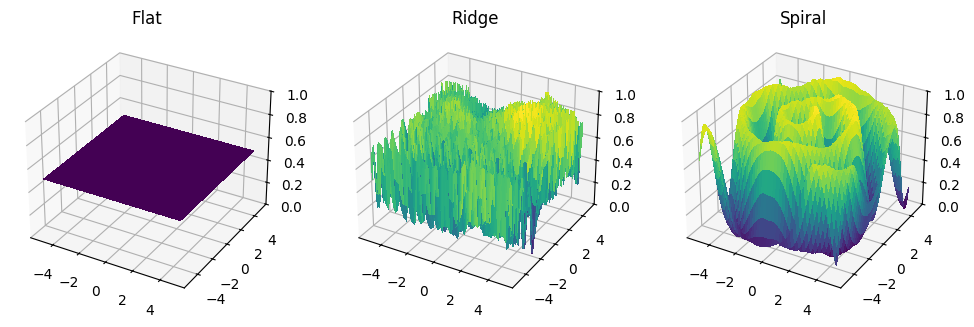

In [70]:
# Generate the skin mesh
flat_mesh = generate_flat(shape=(nx, ny))
ridge_mesh = generate_wave(shape=(nx, ny))
spiral_mesh = generate_spiral(shape=(nx, ny))

# Visualize
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

# set up the figure and Axes
max_res = 25

ax1.plot_surface(X, Y, flat_mesh, cmap=cm.viridis, linewidth=0, antialiased=False)
ax1.set_zlim(0, 1)
ax1.set_title('Flat')

ax2.plot_surface(X, Y, ridge_mesh, cmap=cm.viridis, linewidth=0, antialiased=False)
ax2.set_zlim(0, 1)
ax2.set_title('Ridge')

ax3.plot_surface(X, Y, spiral_mesh, cmap=cm.viridis, linewidth=0, antialiased=False)
ax3.set_zlim(0, 1)
ax3.set_title('Spiral')

plt.show()

In [71]:
# Generate Pressure Signal
pressure_map = create_pressure_map(shape=(nx, ny), pattern_type="circular")

In [72]:
# Solve for skin deformation using IVP for each fingerprint model
flat_sol = compute_deformation(flat_mesh, pressure_map, time)
ridge_sol = compute_deformation(ridge_mesh, pressure_map, time)
spiral_sol = compute_deformation(spiral_mesh, pressure_map, time)

In [73]:
# Compute receptor responses for all models
sa1_out_flat = sa1_response(flat_sol["eps"], flat_sol["curv"])
sa2_out_flat = sa2_response(flat_sol["eps"], flat_sol["curv"])
fa1_out_flat = fa1_response(flat_sol["eps"], flat_sol["curv"])
fa2_out_flat = fa2_response(flat_sol["eps"], flat_sol["curv"])

sa1_out_ridge = sa1_response(ridge_sol["eps"], ridge_sol["curv"])
sa2_out_ridge = sa2_response(ridge_sol["eps"], ridge_sol["curv"])
fa1_out_ridge = fa1_response(ridge_sol["eps"], ridge_sol["curv"])
fa2_out_ridge = fa2_response(ridge_sol["eps"], ridge_sol["curv"])

sa1_out_spiral = sa1_response(spiral_sol["eps"], spiral_sol["curv"])
sa2_out_spiral = sa2_response(spiral_sol["eps"], spiral_sol["curv"])
fa1_out_spiral = fa1_response(spiral_sol["eps"], spiral_sol["curv"])
fa2_out_spiral = fa2_response(spiral_sol["eps"], spiral_sol["curv"])

## Visualization
Visualize the results from the simulation

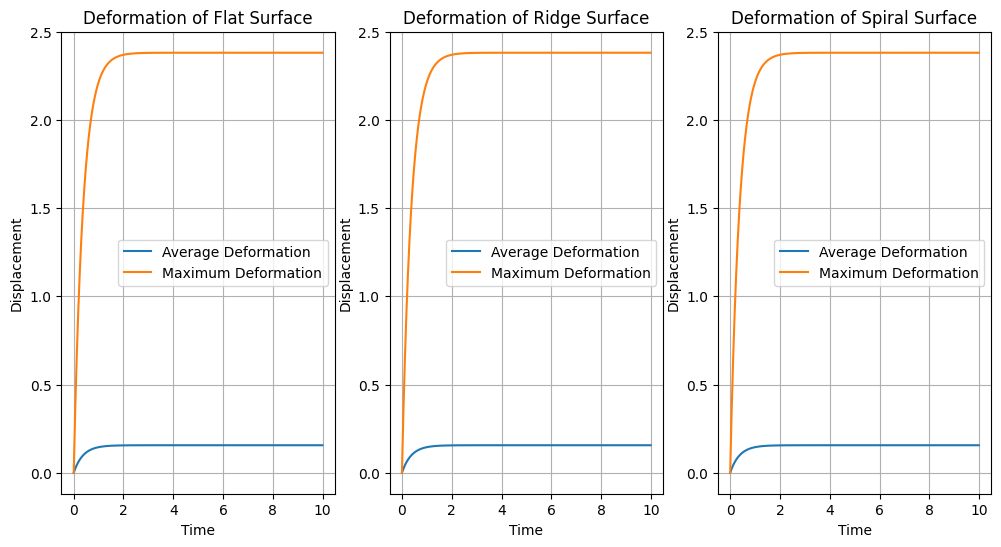

In [74]:
# Plot the deformation over time for all three models
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

# Calculate all maxes and avgs
flat_avg = [flat_sol["eps"][:, :, i].mean() for i in range(len(time))]
flat_max = [flat_sol["eps"][:, :, i].max() for i in range(len(time))]

ridge_avg = [ridge_sol["eps"][:, :, i].mean() for i in range(len(time))]
ridge_max = [ridge_sol["eps"][:, :, i].max() for i in range(len(time))]

spiral_avg = [spiral_sol["eps"][:, :, i].mean() for i in range(len(time))]
spiral_max = [spiral_sol["eps"][:, :, i].max() for i in range(len(time))]

ax1.plot(time, flat_avg, label="Average Deformation")
ax1.plot(time, flat_max, label="Maximum Deformation")
ax1.set_title("Deformation of Flat Surface")
ax1.set_xlabel("Time")
ax1.set_ylabel("Displacement")
ax1.grid(True)
ax1.legend()

ax2.plot(time, ridge_avg, label="Average Deformation")
ax2.plot(time, ridge_max, label="Maximum Deformation")
ax2.set_title("Deformation of Ridge Surface")
ax2.set_xlabel("Time")
ax2.set_ylabel("Displacement")
ax2.grid(True)
ax2.legend()

ax3.plot(time, spiral_avg, label="Average Deformation")
ax3.plot(time, spiral_max, label="Maximum Deformation")
ax3.set_title("Deformation of Spiral Surface")
ax3.set_xlabel("Time")
ax3.set_ylabel("Displacement")
ax3.grid(True)
ax3.legend()

plt.show()

Now we will analysis the responses from each receptor type

In [75]:
# Define points of interest (example - could be specific mechanoreceptor locations)
# Points at center, near center, and periphery
points_of_interest = [
	(nx//2, ny//2),  # Center
	(nx//2 + 10, ny//2 + 10),  # Near center
	(nx//2 - 15, ny//2 + 5),  # Another near center point
	(nx//4, ny//4),  # Periphery
	(3*nx//4, 3*ny//4)  # Opposite periphery
]

In [76]:
def analyze_specific_points(results, points_of_interest):
    """
    Analyze mechanoreceptor responses at specific points of interest over time
    """
    response_data = {}
    
    for idx, (x, y) in enumerate(points_of_interest):
        point_name = f'Point {idx+1} ({x},{y})'
        response_data[point_name] = {
            'SA1': results['sa1'][y, x, :],
            'SA2': results['sa2'][y, x, :],
            'FA1': results['fa1'][y, x, :],
            'FA2': results['fa2'][y, x, :]
        }
        
    return response_data

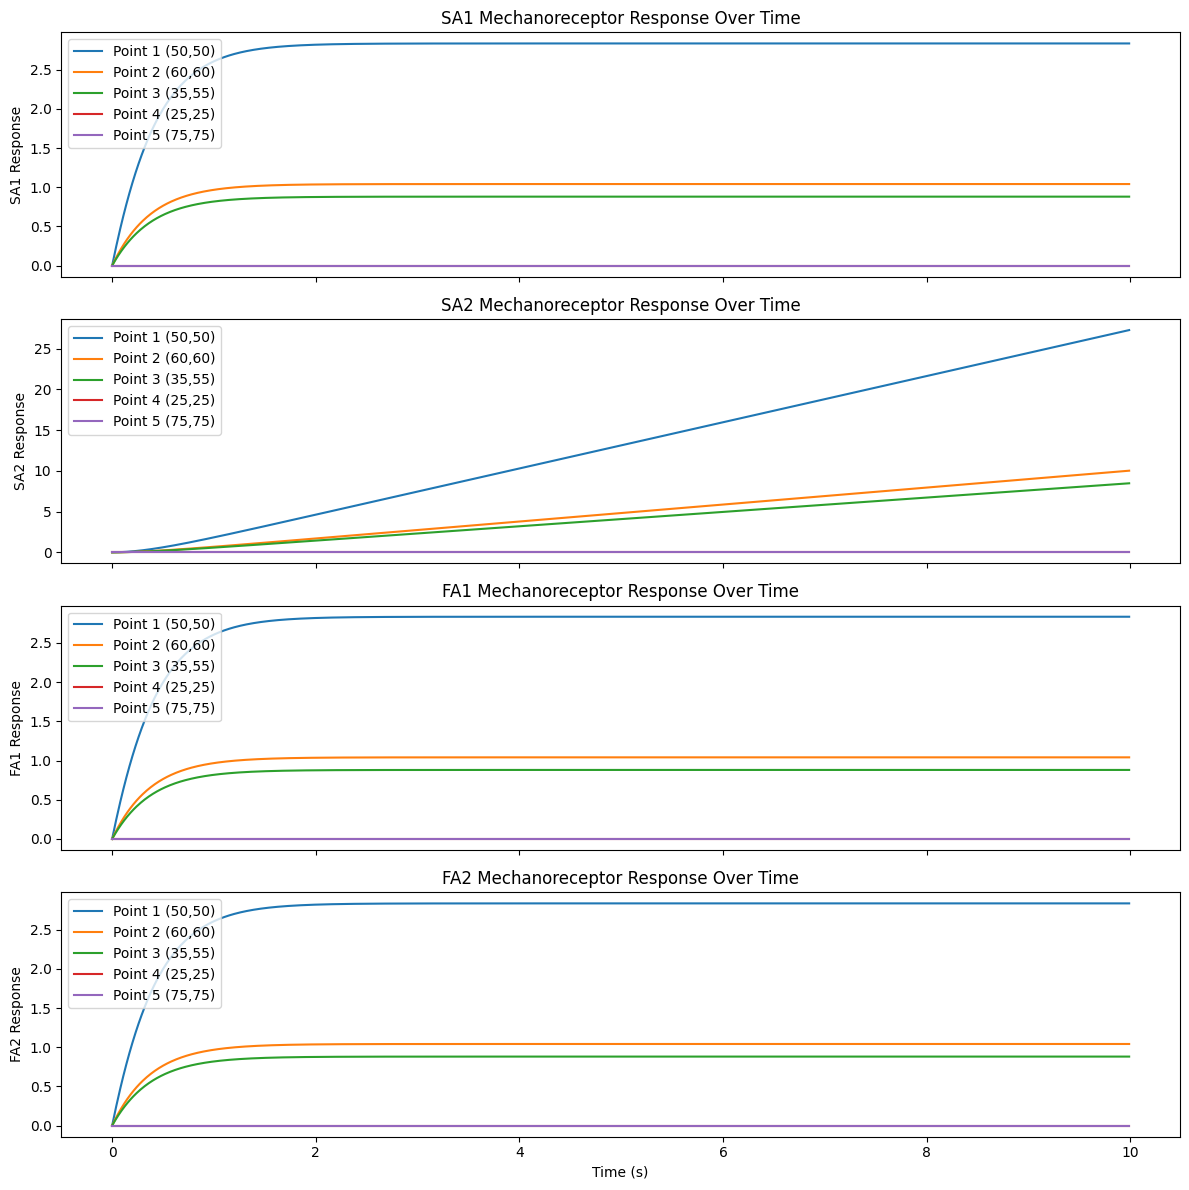

In [77]:
flat_resp = {
	'sa1': sa1_out_flat,
	'sa2': sa2_out_flat,
	'fa1': fa1_out_flat,
	'fa2': fa2_out_flat
}
response_data = analyze_specific_points(flat_resp, points_of_interest)

receptor_types = ['SA1', 'SA2', 'FA1', 'FA2']
num_points = len(response_data)

fig, axs = plt.subplots(len(receptor_types), 1, figsize=(12, 12), sharex=True)

for i, receptor in enumerate(receptor_types):
	for point, data in response_data.items():
		axs[i].plot(time, data[receptor], label=point)
	
	axs[i].set_ylabel(f'{receptor} Response')
	axs[i].set_title(f'{receptor} Mechanoreceptor Response Over Time')
	axs[i].legend()

axs[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

In [78]:
def create_receptor_animation(data, t, receptor_type='sa1', interval=100):
    """
    Create animation of receptor response over time
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    vmin = np.min(data)
    vmax = np.max(data)
    
    # Initial plot
    im = ax.imshow(data[:, :, 0], cmap='viridis', vmin=vmin, vmax=vmax, 
                  extent=[x.min(), x.max(), y.min(), y.max()])
    
    # Add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    
    title = ax.set_title(f'{receptor_type.upper()} Response at t=0')
    
    def update(frame):
        im.set_array(data[:, :, frame])
        title.set_text(f'{receptor_type.upper()} Response at t={t[frame]:.2f}s')
        return [im, title]
    
    ani = FuncAnimation(fig, update, frames=range(0, len(t), interval), 
                        blit=True, interval=50)
    
    plt.tight_layout()
    return ani

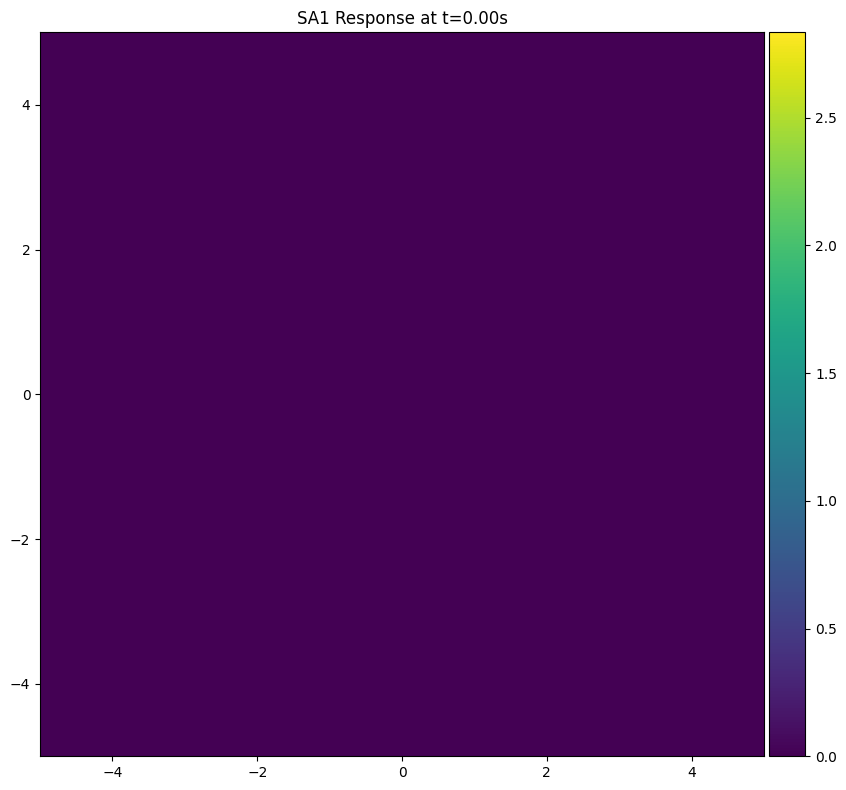

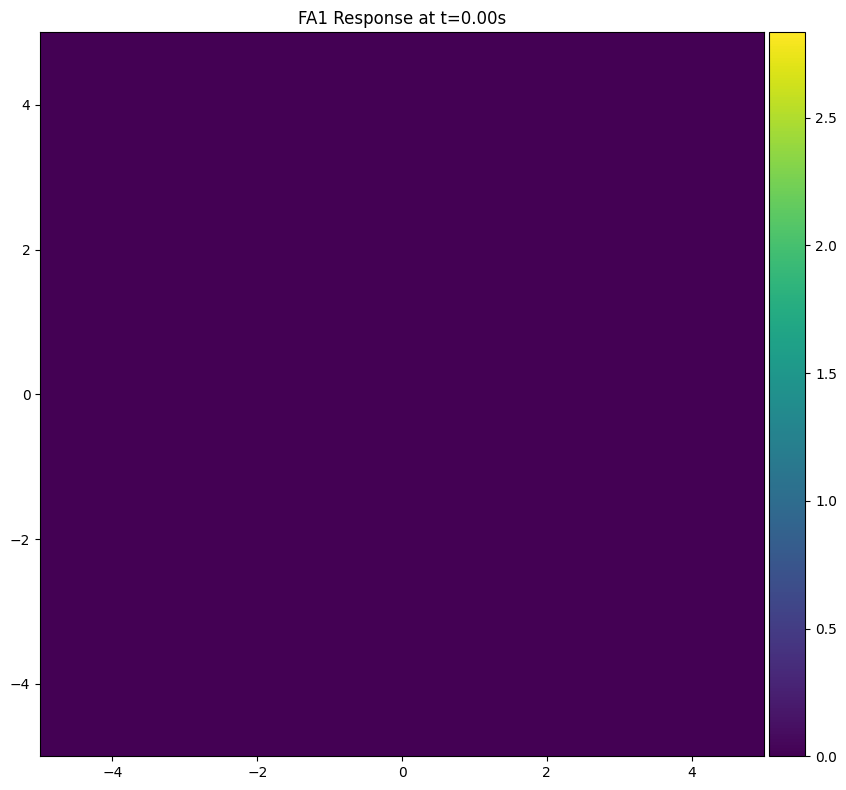

In [79]:
# Create animations
sa1_animation = create_receptor_animation(sa1_out_flat, time, 'sa1')
fa1_animation = create_receptor_animation(fa1_out_flat, time, 'fa1')

In [83]:
def export_data_to_csv(data, t, points_of_interest):
    """
    Export mechanoreceptor response data to CSV for further analysis
    """
    response_data = analyze_specific_points(data, points_of_interest)
    
    # Create DataFrame
    data_frames = []
    
    for point_name, responses in response_data.items():
        for receptor, values in responses.items():
            df = pd.DataFrame({
                'time': t,
                'point': [point_name] * len(t),
                'receptor': [receptor] * len(t),
                'response': values
            })
            data_frames.append(df)
    
    # Combine all data
    result_df = pd.concat(data_frames)
    
    # Export to CSV
    result_df.to_csv('mechanoreceptor_responses.csv', index=False)
    
    # Also create a pivot table for easier analysis
    pivot_df = result_df.pivot_table(
        index=['time'], 
        columns=['point', 'receptor'], 
        values='response'
    )
    
    pivot_df.to_csv('mechanoreceptor_responses_pivot.csv')
    
    return result_df, pivot_df

In [84]:
# Export data
result_df, pivot_df = export_data_to_csv(flat_resp, time, points_of_interest)